# Gaussian Processes vs Kernel Ridge Regression

Analysis code for the portfolio performance dataset.

We use:
- **Inputs**: weights of the stock-picking concepts (6 features).
- **Target**: normalized annual return ("all period" sheet).

## Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.linalg import cholesky, solve_triangular
from scipy.optimize import minimize

## RBF kernel

In [11]:
def rbf_kernel(X1, X2, lengthscale, variance):
    
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    sqdist = (
        np.sum(X1**2, axis=1)[:, None]
        + np.sum(X2**2, axis=1)[None, :]
        - 2.0 * X1.dot(X2.T)
    )
    return variance * np.exp(-0.5 * sqdist / (lengthscale ** 2))

## Gaussian Process regression (zero mean, RBF kernel, Gaussian noise)

In [12]:
def gp_neg_log_marginal_likelihood(theta_log, X, y):
    
    ell, sigma_f, sigma_n = np.exp(theta_log)

    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X.shape[0])
    
    L = cholesky(Ky, lower=True, check_finite=False)


    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    log_det = 2.0 * np.sum(np.log(np.diag(L)))
    n = X.shape[0]
    nll = 0.5 * y.dot(alpha) + 0.5 * log_det + 0.5 * n * np.log(2.0 * np.pi)
    return nll


def gp_fit_marginal_likelihood(X, y, initial_log_theta=None, bounds=None):

    if initial_log_theta is None:
        y_std = np.std(y)
        if y_std == 0:
            y_std = 1.0
        initial = np.log([1.0, y_std, 0.1 * y_std])
    else:
        initial = np.asarray(initial_log_theta)

    if bounds is None:
        bounds = [(-7, 7), (-7, 7), (-7, 7)]

    res = minimize(
        gp_neg_log_marginal_likelihood,
        initial,
        args=(X, y),
        method="L-BFGS-B",
        bounds=bounds,
    )

    ell, sigma_f, sigma_n = np.exp(res.x)
    return {"ell": ell, "sigma_f": sigma_f, "sigma_n": sigma_n, "opt_result": res}


def gp_predict(X_train, y_train, X_test, ell, sigma_f, sigma_n, return_var=True):

    K = rbf_kernel(X_train, X_train, ell, sigma_f ** 2)
    Ky = K + sigma_n ** 2 * np.eye(X_train.shape[0])

    L = cholesky(Ky, lower=True, check_finite=False)
    alpha = solve_triangular(
        L.T,
        solve_triangular(L, y_train, lower=True, check_finite=False),
        lower=False,
        check_finite=False,
    )

    K_star = rbf_kernel(X_train, X_test, ell, sigma_f ** 2)
    mean = K_star.T.dot(alpha)

    if not return_var:
        return mean

    v = solve_triangular(L, K_star, lower=True, check_finite=False)
    K_starstar = rbf_kernel(X_test, X_test, ell, sigma_f ** 2)
    cov = K_starstar - v.T.dot(v)
    var = np.clip(np.diag(cov), 0.0, np.inf)

    return mean, var


def gaussian_nlpd(y_true, y_mean, y_var, min_var=1e-9):

    y_true = np.asarray(y_true).ravel()
    y_mean = np.asarray(y_mean).ravel()
    y_var  = np.asarray(y_var).ravel()
    y_var = np.maximum(y_var, min_var)

    return 0.5 * np.log(2.0 * np.pi * y_var) + 0.5 * (y_true - y_mean) ** 2 / y_var


def gp_cross_validation(
    X, y,
    ell_grid, sigma_f_grid, sigma_n_grid,
    n_splits=5, random_state=0,
    objective="nlpd",
    verbose=False,
):

    if objective not in {"nlpd", "mse"}:
        raise ValueError("objective must be either 'nlpd' or 'mse'.")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_score = np.inf
    best_params = None
    best_mse = np.inf
    best_nlpd = np.inf

    rows = []

    for ell in ell_grid:
        for sigma_f in sigma_f_grid:
            for sigma_n in sigma_n_grid:

                fold_mse = []
                fold_nlpd = []

                for train_idx, val_idx in kf.split(X):
                    X_tr, X_val = X[train_idx], X[val_idx]
                    y_tr, y_val = y[train_idx], y[val_idx]

                    mu_val, var_f_val = gp_predict(
                        X_tr, y_tr, X_val,
                        ell, sigma_f, sigma_n,
                        return_var=True,
                    )

                    fold_mse.append(mean_squared_error(y_val, mu_val))

                    var_y_val = var_f_val + sigma_n ** 2
                    fold_nlpd.append(float(np.mean(gaussian_nlpd(y_val, mu_val, var_y_val))))

                mean_mse = float(np.mean(fold_mse))
                mean_nlpd = float(np.mean(fold_nlpd))

                rows.append(
                    {
                        "ell": float(ell),
                        "sigma_f": float(sigma_f),
                        "sigma_n": float(sigma_n),
                        "cv_mse": mean_mse,
                        "cv_nlpd": mean_nlpd,
                    }
                )

                score = mean_nlpd if objective == "nlpd" else mean_mse
                if score < best_score:
                    best_score = score
                    best_mse = mean_mse
                    best_nlpd = mean_nlpd
                    best_params = {"ell": float(ell), "sigma_f": float(sigma_f), "sigma_n": float(sigma_n)}

                if verbose:
                    print(
                        f"[GP-CV] ell={ell:.3g}, sigma_f={sigma_f:.3g}, sigma_n={sigma_n:.3g} "
                        f"-> CV MSE={mean_mse:.4e}, CV NLPD={mean_nlpd:.4e}"
                    )

    cv_results = pd.DataFrame(rows)
    sort_key = "cv_nlpd" if objective == "nlpd" else "cv_mse"
    cv_results = cv_results.sort_values(sort_key, ascending=True).reset_index(drop=True)

    return best_params, best_mse, best_nlpd, cv_results


## Kernel Ridge Regression

In [13]:
def krr_fit(X, y, lambd_eff, ell, sigma_f):

    n = X.shape[0]
    K = rbf_kernel(X, X, ell, sigma_f ** 2)
    A = K + float(lambd_eff) * np.eye(n)
    coef = np.linalg.solve(A, y)
    return {
        "X_train": X.copy(),
        "coef": coef,
        "ell": float(ell),
        "sigma_f": float(sigma_f),
        "lambd_eff": float(lambd_eff),
    }


def krr_predict(model, X_test):

    K_star = rbf_kernel(
        model["X_train"], X_test,
        model["ell"], model["sigma_f"] ** 2
    )
    return K_star.T.dot(model["coef"])


def krr_cross_validation(X, y, lambd_eff_grid, ell_grid, sigma_f_grid,
                         n_splits=5, random_state=0, verbose=False):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_mse = np.inf
    best_params = None

    for ell in ell_grid:
        for sigma_f in sigma_f_grid:
            K_full = rbf_kernel(X, X, ell, sigma_f ** 2)

            for lambd_eff in lambd_eff_grid:
                fold_mses = []

                for tr_idx, va_idx in kf.split(X):
                    y_tr, y_va = y[tr_idx], y[va_idx]

                    K_tr = K_full[np.ix_(tr_idx, tr_idx)]
                    K_va = K_full[np.ix_(tr_idx, va_idx)]

                    A = K_tr + float(lambd_eff) * np.eye(len(tr_idx))
                    coef = np.linalg.solve(A, y_tr)

                    y_hat = K_va.T.dot(coef)
                    fold_mses.append(np.mean((y_va - y_hat) ** 2))

                mean_mse = float(np.mean(fold_mses))

                if mean_mse < best_mse:
                    best_mse = mean_mse
                    best_params = {
                        "lambd_eff": float(lambd_eff),
                        "ell": float(ell),
                        "sigma_f": float(sigma_f),
                    }
                    if verbose:
                        print("New best:", best_params, "CV MSE:", best_mse)

    return best_params, best_mse

## Data loading: portfolio dataset (`all period` sheet)

In [14]:
def load_portfolio_dataset_all_period(path):

    xls = pd.ExcelFile(path)
    df = pd.read_excel(xls, sheet_name="all period", header=[0, 1])

    weight_cols = [
        col for col in df.columns
        if col[0].startswith("the weight")
    ]

    target_col = (
        'the normalized  investment performance indicator',
        'Annual Return',
    )

    df_sub = df[weight_cols + [target_col]].dropna()
    X = df_sub[weight_cols].to_numpy(dtype=float)
    y = df_sub[target_col].to_numpy(dtype=float)

    return X, y

## Full experiment: GP-ML, GP-CV, KRR-CV

In [ ]:
def run_experiment_with_gp_and_krr(path, test_size=0.3, random_state=0):

    X, y = load_portfolio_dataset_all_period(path)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    X_scaler = StandardScaler().fit(X_train)
    X_train_s = X_scaler.transform(X_train)
    X_test_s = X_scaler.transform(X_test)

    y_mean = float(np.mean(y_train))
    y_std = float(np.std(y_train))
    if y_std == 0:
        y_std = 1.0
    y_train_s = (y_train - y_mean) / y_std

    print("Training points:", X_train_s.shape[0], " Test points:", X_test_s.shape[0])

    # 1) GP via marginal likelihood
    print("\nFitting GP (RBF kernel) by marginal likelihood...")
    gp_ml_params = gp_fit_marginal_likelihood(X_train_s, y_train_s)
    print("GP-ML hyperparameters (scaled space):")
    print(gp_ml_params)

    gp_ml_mean_s, gp_ml_var_f_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s
    gp_ml_var_y = (gp_ml_var_f_s + gp_ml_params["sigma_n"] ** 2) * (y_std ** 2)
    gp_ml_mse = float(mean_squared_error(y_test, gp_ml_mean))
    gp_ml_nlpd = float(np.mean(gaussian_nlpd(y_test, gp_ml_mean, gp_ml_var_y)))

    print(f"GP-ML test MSE:  {gp_ml_mse:.6f}")
    print(f"GP-ML mean NLPD: {gp_ml_nlpd:.6f}")

    # 2) GP via cross-validation
    print("\nTuning GP hyperparameters by cross-validation (grid search)...")

    ell_grid = np.linspace(2.5, 3.5, 30)
    sigma_f_grid = np.linspace(1.1, 1.3, 30)
    sigma_n_grid = np.logspace(np.log10(0.03), np.log10(0.10), 30)

    #   (i)  minimize CV MSE
    #   (ii) minimize CV NLPD
    gp_cv_nlpd_best, gp_cv_nlpd_cv_mse, gp_cv_nlpd_cv_nlpd, gp_cv_nlpd_cv_results = gp_cross_validation(
        X_train_s, y_train_s,
        ell_grid, sigma_f_grid, sigma_n_grid,
        n_splits=5, random_state=random_state, objective="nlpd", verbose=False,
    )
    gp_cv_mse_best, gp_cv_mse_cv_mse, gp_cv_mse_cv_nlpd, gp_cv_mse_cv_results = gp_cross_validation(
        X_train_s, y_train_s,
        ell_grid, sigma_f_grid, sigma_n_grid,
        n_splits=5, random_state=random_state, objective="mse", verbose=False,
    )

    print("\nBest GP-CV hyperparameters (select by NLPD, scaled space):")
    print(gp_cv_nlpd_best)
    print(f"  CV NLPD (scaled y): {gp_cv_nlpd_cv_nlpd:.6f}")
    print(f"  CV MSE  (scaled y): {gp_cv_nlpd_cv_mse:.6f}")

    print("\nBest GP-CV hyperparameters (select by MSE, scaled space):")
    print(gp_cv_mse_best)
    print(f"  CV MSE  (scaled y): {gp_cv_mse_cv_mse:.6f}")
    print(f"  CV NLPD (scaled y): {gp_cv_mse_cv_nlpd:.6f}")

    def _evaluate_gp_on_test(params, label):
        mean_s, var_f_s = gp_predict(
            X_train_s, y_train_s, X_test_s,
            params["ell"], params["sigma_f"], params["sigma_n"],
            return_var=True,
        )
        mean = y_mean + y_std * mean_s

        var_y = (var_f_s + params["sigma_n"] ** 2) * (y_std ** 2)

        mse = float(mean_squared_error(y_test, mean))
        nlpd = float(np.mean(gaussian_nlpd(y_test, mean, var_y)))

        print(f"{label} test MSE:  {mse:.6f}")
        print(f"{label} mean NLPD: {nlpd:.6f}")
        return {"mean": mean, "var_y": var_y, "mse": mse, "nlpd": nlpd}

    gp_cv_nlpd_eval = _evaluate_gp_on_test(gp_cv_nlpd_best, "GP-CV (select NLPD)")
    gp_cv_mse_eval  = _evaluate_gp_on_test(gp_cv_mse_best,  "GP-CV (select MSE)")

    # 3) KRR via cross-validation
    print("\nTuning Kernel Ridge Regression by cross-validation...")

    lambd_eff_grid = sigma_n_grid ** 2
    ell_grid_krr = ell_grid
    sigma_f_grid_krr = sigma_f_grid

    krr_best, krr_best_mse_cv = krr_cross_validation(
        X_train_s, y_train_s,
        lambd_eff_grid, ell_grid_krr, sigma_f_grid_krr,
        n_splits=5, random_state=random_state, verbose=False,
    )

    n_train_full = X_train_s.shape[0]
    krr_best["lambd"] = krr_best["lambd_eff"] / n_train_full 

    print("Best KRR hyperparameters (scaled space):")
    print(krr_best)
    print(f"Best KRR CV MSE (scaled y): {krr_best_mse_cv:.6f}")
    print(f"  (lambda_eff = {krr_best['lambd_eff']:.6g},  lambda = {krr_best['lambd']:.6g} using n_train={n_train_full})")

    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd_eff"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s
    krr_mse = float(mean_squared_error(y_test, krr_pred))
    print(f"KRR test MSE: {krr_mse:.6f}")

    # 4) Comparison GP mean - KRR
    gp_ml_mean_s_only = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=False,
    )
    diff = gp_ml_mean_s_only - krr_pred_s
    print("\nDifference between GP-ML mean and KRR prediction (scaled y):")
    print(f"  Mean |diff|: {np.mean(np.abs(diff)):.4e}")
    print(f"  Max  |diff|: {np.max(np.abs(diff)):.4e}")

    # 5) Summary of results
    summary = pd.DataFrame(
        {
            "Test MSE": [
                gp_ml_mse,
                gp_cv_nlpd_eval["mse"],
                gp_cv_mse_eval["mse"],
                krr_mse,
            ],
            "Mean NLPD": [
                gp_ml_nlpd,
                gp_cv_nlpd_eval["nlpd"],
                gp_cv_mse_eval["nlpd"],
                np.nan,
            ],
            "CV MSE (scaled y)": [
                np.nan,
                gp_cv_nlpd_cv_mse,
                gp_cv_mse_cv_mse,
                krr_best_mse_cv,
            ],
            "CV NLPD (scaled y)": [
                np.nan,
                gp_cv_nlpd_cv_nlpd,
                gp_cv_mse_cv_nlpd,
                np.nan,
            ],
            "ell": [
                gp_ml_params["ell"],
                gp_cv_nlpd_best["ell"],
                gp_cv_mse_best["ell"],
                krr_best["ell"],
            ],
            "sigma_f": [
                gp_ml_params["sigma_f"],
                gp_cv_nlpd_best["sigma_f"],
                gp_cv_mse_best["sigma_f"],
                krr_best["sigma_f"],
            ],
            "sigma_n": [
                gp_ml_params["sigma_n"],
                gp_cv_nlpd_best["sigma_n"],
                gp_cv_mse_best["sigma_n"],
                np.nan,
            ],
            "sigma_n^2 / n_train": [
                (gp_ml_params["sigma_n"] ** 2) / n_train_full,
                (gp_cv_nlpd_best["sigma_n"] ** 2) / n_train_full,
                (gp_cv_mse_best["sigma_n"] ** 2) / n_train_full,
                np.nan,
            ],
            "lambda_eff": [
                np.nan,
                np.nan,
                np.nan,
                krr_best["lambd_eff"],
            ],
            "lambda": [
                np.nan,
                np.nan,
                np.nan,
                krr_best["lambd"],
            ],
        },
        index=["GP-ML", "GP-CV (select NLPD)", "GP-CV (select MSE)", "KRR-CV"],
    )

    print("\n========== Summary of results ==========")
    print(summary)
    print("========================================\n")

    results = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_s": X_train_s,
        "X_test_s": X_test_s,
        "y_train_s": y_train_s,

        "gp_ml_params": gp_ml_params,
        "gp_ml_test_mse": gp_ml_mse,
        "gp_ml_test_nlpd": gp_ml_nlpd,

        "gp_cv_nlpd_best": gp_cv_nlpd_best,
        "gp_cv_nlpd_cv_mse": gp_cv_nlpd_cv_mse,
        "gp_cv_nlpd_cv_nlpd": gp_cv_nlpd_cv_nlpd,
        "gp_cv_nlpd_cv_results": gp_cv_nlpd_cv_results,
        "gp_cv_nlpd_test_mse": gp_cv_nlpd_eval["mse"],
        "gp_cv_nlpd_test_nlpd": gp_cv_nlpd_eval["nlpd"],

        "gp_cv_mse_best": gp_cv_mse_best,
        "gp_cv_mse_cv_mse": gp_cv_mse_cv_mse,
        "gp_cv_mse_cv_nlpd": gp_cv_mse_cv_nlpd,
        "gp_cv_mse_cv_results": gp_cv_mse_cv_results,
        "gp_cv_mse_test_mse": gp_cv_mse_eval["mse"],
        "gp_cv_mse_test_nlpd": gp_cv_mse_eval["nlpd"],

        "krr_best": krr_best,
        "krr_cv_mse_scaled": krr_best_mse_cv,
        "krr_test_mse": krr_mse,
    }

    return results

## Plots

In [ ]:
def _recompute_scalers(results):

    X_train = results["X_train"]
    y_train = results["y_train"]

    X_scaler = StandardScaler().fit(X_train)
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    if y_std == 0:
        y_std = 1.0

    return X_scaler, y_mean, y_std



def plot_parity(results, save_path=None):

    X_train_s = results["X_train_s"]
    X_test_s  = results["X_test_s"]
    y_train_s = results["y_train_s"]
    y_test    = results["y_test"]

    _, y_mean, y_std = _recompute_scalers(results)

    gp_ml_params = results["gp_ml_params"]
    gp_ml_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=False,
    )
    gp_ml_mean = y_mean + y_std * gp_ml_mean_s

    gp_cv_nlpd_best = results["gp_cv_nlpd_best"]
    gp_cv_nlpd_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_nlpd_best["ell"], gp_cv_nlpd_best["sigma_f"], gp_cv_nlpd_best["sigma_n"],
        return_var=False,
    )
    gp_cv_nlpd_mean = y_mean + y_std * gp_cv_nlpd_mean_s

    gp_cv_mse_best = results["gp_cv_mse_best"]
    gp_cv_mse_mean_s = gp_predict(
        X_train_s, y_train_s, X_test_s,
        gp_cv_mse_best["ell"], gp_cv_mse_best["sigma_f"], gp_cv_mse_best["sigma_n"],
        return_var=False,
    )
    gp_cv_mse_mean = y_mean + y_std * gp_cv_mse_mean_s

    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd_eff"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s = krr_predict(krr_model, X_test_s)
    krr_pred = y_mean + y_std * krr_pred_s

    models = [
        ("GP-ML", gp_ml_mean),
        ("GP-CV (NLPD)", gp_cv_nlpd_mean),
        ("GP-CV (MSE)", gp_cv_mse_mean),
        ("KRR-CV", krr_pred),
    ]

    global_min = float(min(np.min(y_test), *(np.min(m[1]) for m in models)))
    global_max = float(max(np.max(y_test), *(np.max(m[1]) for m in models)))

    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    markers = ["o", "s", "^", "D"]

    for (name, y_pred), mk in zip(models, markers):
        ax1.scatter(y_test, y_pred, alpha=0.75, marker=mk, label=name)

    ax1.plot([global_min, global_max], [global_min, global_max], linestyle="--")
    ax1.set_xlim(global_min, global_max)
    ax1.set_ylim(global_min, global_max)
    ax1.set_xlabel("True normalized annual return")
    ax1.set_ylabel("Predicted normalized annual return")
    ax1.set_title("Parity (all methods overlaid)")
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    baseline = gp_ml_mean

    for (name, y_pred), mk in zip(models[1:], markers[1:]):
        delta = y_pred - baseline
        ax2.scatter(y_test, delta, alpha=0.75, marker=mk, label=f"{name} − GP-ML")

    ax2.axhline(0.0, linestyle="--")
    ax2.set_xlabel("True normalized annual return")
    ax2.set_ylabel("Prediction difference")
    ax2.set_title("Differences relative to GP-ML")
    ax2.legend()

    fig.suptitle("Test set diagnostics", y=1.02)
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



def plot_1d_slice(results, feature_index=0, feature_names=None,
                  n_points=200, save_path=None):

    X_train = results["X_train"]
    y_train = results["y_train"]
    X_train_s = results["X_train_s"]
    y_train_s = results["y_train_s"]

    X_scaler, y_mean, y_std = _recompute_scalers(results)

    x0_s = X_train_s.mean(axis=0)
    f = feature_index

    f_min = X_train_s[:, f].min()
    f_max = X_train_s[:, f].max()
    grid_f = np.linspace(f_min, f_max, n_points)

    X_grid_s = np.tile(x0_s, (n_points, 1))
    X_grid_s[:, f] = grid_f

    X_grid = X_scaler.inverse_transform(X_grid_s)
    x_axis = X_grid[:, f]

    gp_ml_params = results["gp_ml_params"]
    gp_ml_mean_s_grid, gp_ml_var_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_ml_params["ell"], gp_ml_params["sigma_f"], gp_ml_params["sigma_n"],
        return_var=True,
    )
    gp_ml_mean_grid = y_mean + y_std * gp_ml_mean_s_grid

    gp_cv_nlpd_best = results["gp_cv_nlpd_best"]
    gp_cv_nlpd_mean_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_cv_nlpd_best["ell"], gp_cv_nlpd_best["sigma_f"], gp_cv_nlpd_best["sigma_n"],
        return_var=False,
    )
    gp_cv_nlpd_mean_grid = y_mean + y_std * gp_cv_nlpd_mean_s_grid

    gp_cv_mse_best = results["gp_cv_mse_best"]
    gp_cv_mse_mean_s_grid = gp_predict(
        X_train_s, y_train_s, X_grid_s,
        gp_cv_mse_best["ell"], gp_cv_mse_best["sigma_f"], gp_cv_mse_best["sigma_n"],
        return_var=False,
    )
    gp_cv_mse_mean_grid = y_mean + y_std * gp_cv_mse_mean_s_grid
    gp_ml_std_grid = np.sqrt(gp_ml_var_s_grid) * y_std

    krr_best = results["krr_best"]
    krr_model = krr_fit(
        X_train_s, y_train_s,
        krr_best["lambd_eff"], krr_best["ell"], krr_best["sigma_f"],
    )
    krr_pred_s_grid = krr_predict(krr_model, X_grid_s)
    krr_pred_grid = y_mean + y_std * krr_pred_s_grid

    X_train_orig = X_train
    x_train_axis = X_train_orig[:, f]
    y_train_axis = y_train

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(x_axis, gp_ml_mean_grid, label="GP-ML mean")
    ax.fill_between(
        x_axis,
        gp_ml_mean_grid - 2 * gp_ml_std_grid,
        gp_ml_mean_grid + 2 * gp_ml_std_grid,
        alpha=0.3,
        label="GP-ML ± 2 std",
    )

    ax.plot(x_axis, gp_cv_nlpd_mean_grid, linestyle="-.", label="GP-CV (NLPD) mean")
    ax.plot(x_axis, gp_cv_mse_mean_grid, linestyle=":", label="GP-CV (MSE) mean")
    ax.plot(x_axis, krr_pred_grid, linestyle="--", label="KRR-CV")

    ax.scatter(x_train_axis, y_train_axis, alpha=0.7, label="Train data")

    if feature_names is not None and feature_index < len(feature_names):
        xlabel = feature_names[feature_index]
    else:
        xlabel = f"Input feature {feature_index} (original scale)"

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Normalized annual return")
    ax.set_title(f"1D slice along feature {feature_index}")
    ax.legend()
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



def make_all_plots(results, feature_names=None):

    plot_parity(results, save_path="parity_plot.png")

    n_features = results["X_train"].shape[1]
    for f in range(n_features):
        fname = f"slice_feature{f}.png"
        plot_1d_slice(results,
                      feature_index=f,
                      feature_names=feature_names,
                      save_path=fname)    

## Run Regression

In [17]:
DATA_PATH = "stock portfolio performance data set.xlsx"

results = run_experiment_with_gp_and_krr(DATA_PATH)

Training points: 44  Test points: 19

Fitting GP (RBF kernel) by marginal likelihood...
GP-ML hyperparameters (scaled space):
{'ell': np.float64(2.8143007329579977), 'sigma_f': np.float64(1.2635669304580177), 'sigma_n': np.float64(0.08822623525913055), 'opt_result':   message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 21.55434010226536
        x: [ 1.035e+00  2.339e-01 -2.428e+00]
      nit: 13
      jac: [ 4.619e-05  7.390e-05  3.908e-06]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>}
GP-ML test MSE:  0.001822
GP-ML mean NLPD: -1.780339

Tuning GP hyperparameters by cross-validation (grid search)...

Best GP-CV hyperparameters (select by NLPD, scaled space):
{'ell': 2.6724137931034484, 'sigma_f': 1.203448275862069, 'sigma_n': 0.09203211376401649}
  CV NLPD (scaled y): 0.166251
  CV MSE  (scaled y): 0.192707

Best GP-CV hyperparameters (select by MSE, scaled space):
{'ell': 3.293103448275862, 'sigm

## Run Plots

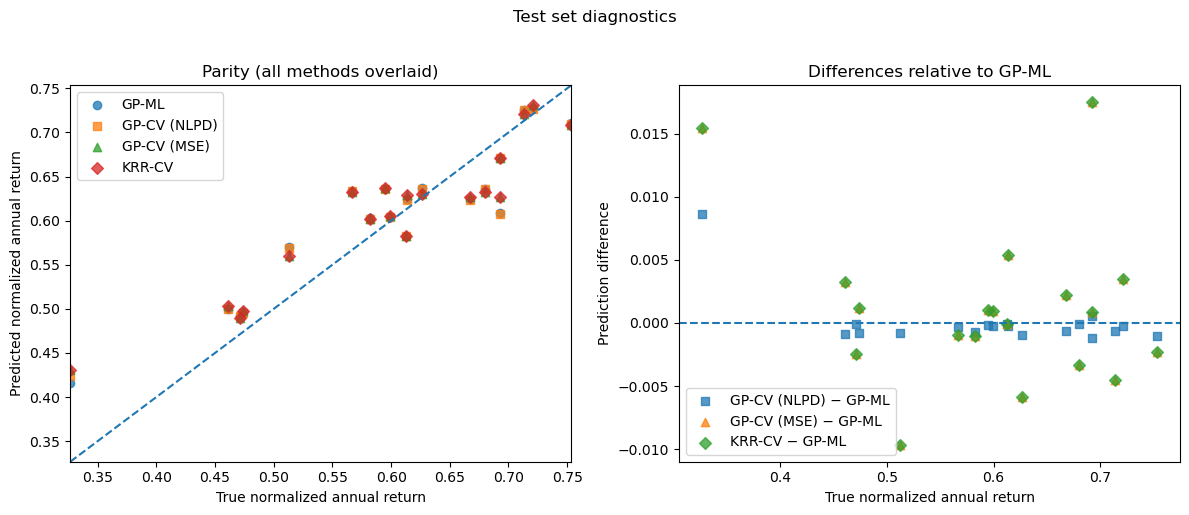

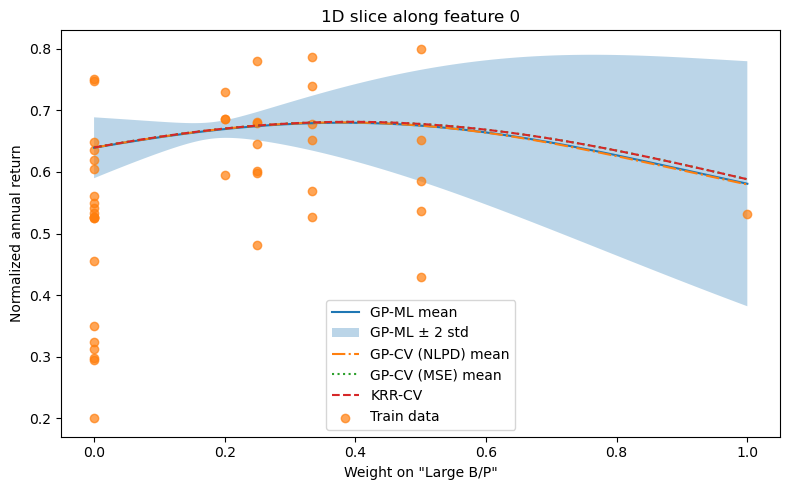

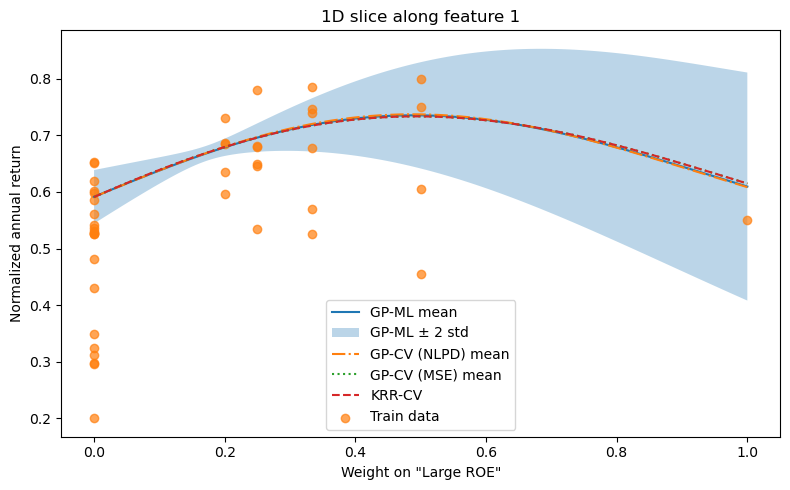

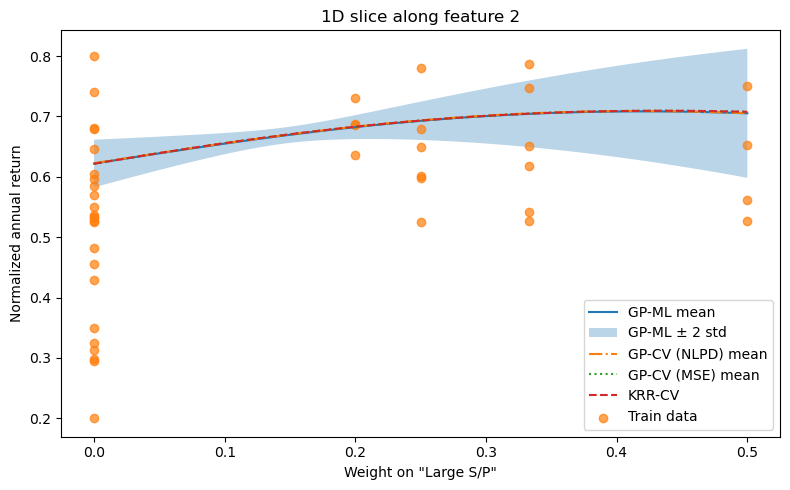

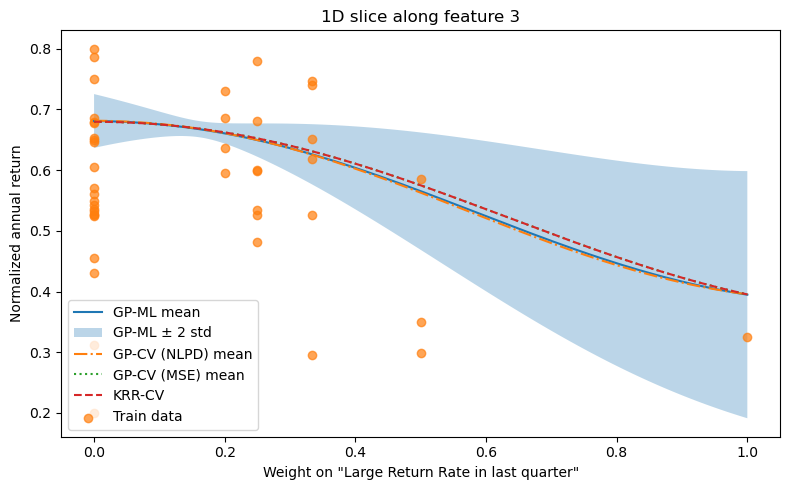

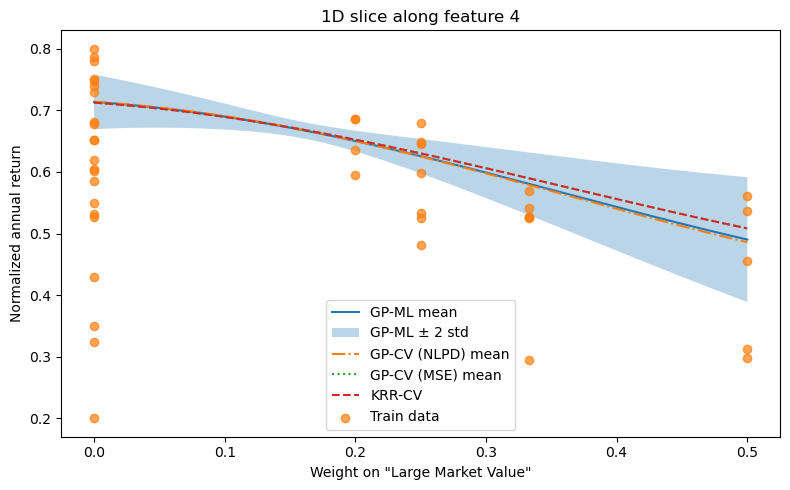

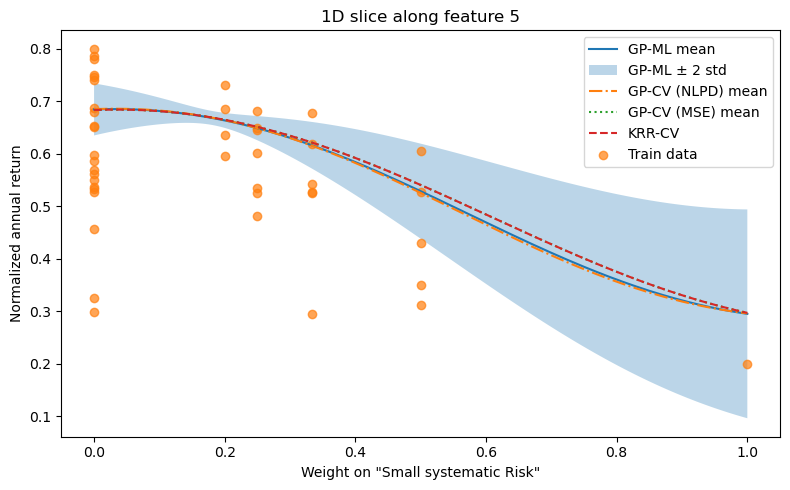

In [ ]:
feature_names = [
    'Weight on "Large B/P"',
    'Weight on "Large ROE"',
    'Weight on "Large S/P"',
    'Weight on "Large Return Rate in last quarter"',
    'Weight on "Large Market Value"',
    'Weight on "Small systematic Risk"',
]

make_all_plots(results, feature_names=feature_names)